## 1. Import all required packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(111)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential

import torch
from pytorch_pretrained_bert import *

import nltk
import gensim
from gensim.models import Word2Vec

print(os.listdir("../input/news-headlines-dataset-for-sarcasm-detection/"))

Using TensorFlow backend.


['Sarcasm_Headlines_Dataset_v2.json', 'Sarcasm_Headlines_Dataset.json']


## 2. Load data from dataset into dataframe

In [2]:
news_df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines = True)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
article_link    26709 non-null object
headline        26709 non-null object
is_sarcastic    26709 non-null int64
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [3]:
# for this workshop let's take only first 5000 records
news_df = news_df[:5000]
news_df.shape

(5000, 3)

In [4]:
news_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
news_df['headline'][2]

"mom starting to fear son's web series closest thing she will have to grandchild"

## 3. Drop the column that is not required for data analysis

In [6]:
news_df = news_df.drop(['article_link'], axis = 1)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
headline        5000 non-null object
is_sarcastic    5000 non-null int64
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [7]:
news_df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


## 4. Data visualization

In [8]:
sarcastic_count = len(news_df[news_df['is_sarcastic'] == 1])
nonsarcastic_count = len(news_df[news_df['is_sarcastic'] == 0])

print(f"Sarcastic headlines count = {sarcastic_count}\nNon-sarcastic headlines count = {nonsarcastic_count}")
print(f"\nSarcastic headlines count + Non-sarcastic headlines count == Total no. of rows in the dataframe ?\nAns: {(sarcastic_count + nonsarcastic_count)==news_df.shape[0]}")

Sarcastic headlines count = 2187
Non-sarcastic headlines count = 2813

Sarcastic headlines count + Non-sarcastic headlines count == Total no. of rows in the dataframe ?
Ans: True


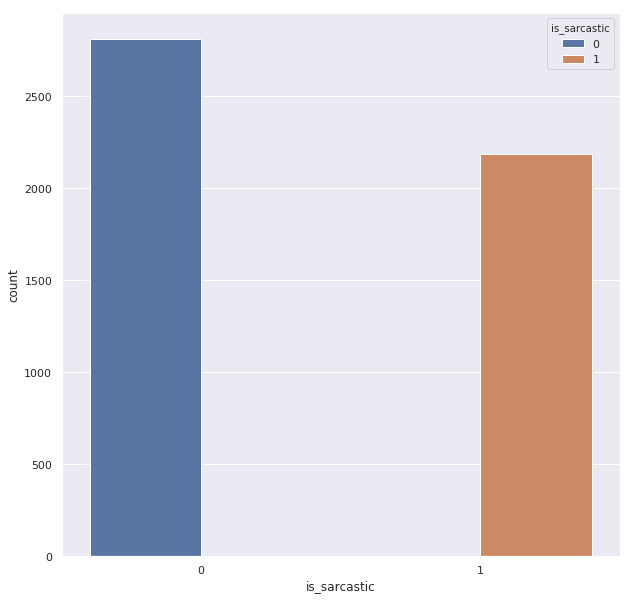

In [9]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.countplot(x = "is_sarcastic", hue = "is_sarcastic", data = news_df)

## 5. Prepare data for training and testing

In [10]:
NUM_OF_FEATURES = 1000
NUM_OF_EMBEDDINGS = 300
MAX_SEQ_LEN = 25

headlines = news_df['headline']
keras_tokenizer = Tokenizer(num_words = NUM_OF_FEATURES)
keras_tokenizer.fit_on_texts(list(headlines))
X = keras_tokenizer.texts_to_sequences(headlines)
X = pad_sequences(X, maxlen = MAX_SEQ_LEN)

y = news_df['is_sarcastic']
print(f"Len of X = {len(X)}, Len of y = {len(y)}")

Len of X = 5000, Len of y = 5000


## 6. A simple LSTM model for sarcasm detection

In [11]:
# init training and testing constants
EPOCHS = 10
BATCH_SIZE = 100
TRAIN_TEST_SPLIT = 0.3

In [12]:
model = Sequential()
model.add(Embedding(NUM_OF_FEATURES, NUM_OF_EMBEDDINGS))
model.add(LSTM(128, return_sequences = True))
model.add(GlobalMaxPool1D())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         300000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         219648    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)               

In [13]:
history = model.fit(X, y, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = TRAIN_TEST_SPLIT)

Train on 3500 samples, validate on 1500 samples
Epoch 1/10
3500/3500 [==============================] - 3s 904us/step - loss: 0.6851 - accuracy: 0.5637 - val_loss: 0.6679 - val_accuracy: 0.5593
Epoch 2/10
3500/3500 [==============================] - 3s 714us/step - loss: 0.6093 - accuracy: 0.6411 - val_loss: 0.5179 - val_accuracy: 0.7720
Epoch 3/10
3500/3500 [==============================] - 3s 717us/step - loss: 0.4880 - accuracy: 0.7880 - val_loss: 0.4599 - val_accuracy: 0.7947
Epoch 4/10
3500/3500 [==============================] - 2s 709us/step - loss: 0.3942 - accuracy: 0.8477 - val_loss: 0.4701 - val_accuracy: 0.7847
Epoch 5/10
3500/3500 [==============================] - 3s 732us/step - loss: 0.3418 - accuracy: 0.8729 - val_loss: 0.5135 - val_accuracy: 0.7800
Epoch 6/10
3500/3500 [==============================] - 2s 707us/step - loss: 0.2980 - accuracy: 0.8883 - val_loss: 0.5925 - val_accuracy: 0.7713
Epoch 7/10
3500/3500 [==============================] - 3s 731us/step - loss

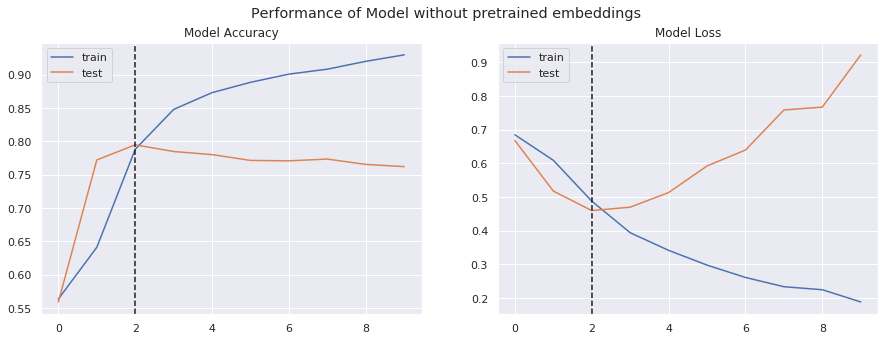

In [14]:
def showTrainingGraphs(history):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.suptitle("Performance of Model without pretrained embeddings")
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
    ax1.axvline(x=vline_cut, color='k', linestyle='--')
    ax1.set_title("Model Accuracy")
    ax1.legend(['train', 'test'])

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
    ax2.axvline(x=vline_cut, color='k', linestyle='--')
    ax2.set_title("Model Loss")
    ax2.legend(['train', 'test'])
    plt.show()
    
showTrainingGraphs(history)

In [34]:
def getSarcasmPrediction(headline, model):
    headline_stmt = headline
    headline = keras_tokenizer.texts_to_sequences(headline)
    headline = pad_sequences(headline, maxlen = 25, dtype='int32', value=0)

    sentiment = model.predict(headline, batch_size=1, verbose = 2)[0]
    sentiment = int(round(sentiment[0]))

    if sentiment == 0:
        print(f"\nHeadline '{headline_stmt}' => {sentiment} Non-sarcastic")
    elif sentiment == 1:
        print(f"\nHeadline '{headline_stmt}' => {sentiment} Sarcastic")
        
headlines = ["you look like clown", "Xiaomi Redmi Note 8 to get 8 GB RAM soon", "Cows lose their job as milk prices drop", "Goat accused of robbery", "India sent 20 billion WhatsApp messages on New Year's eve"]
for headline in headlines:
    getSarcasmPrediction(headline, model)
    
# 2 wrong predictions
# Headline 'Xiaomi Redmi Note 8 to get 8 GB RAM soon' => 1 Sarcastic
# Headline 'Cows lose their job as milk prices drop' => 0 Non-sarcastic


Headline 'you look like clown' => 1 Sarcastic

Headline 'Xiaomi Redmi Note 8 to get 8 GB RAM soon' => 1 Sarcastic

Headline 'Cows lose their job as milk prices drop' => 0 Non-sarcastic

Headline 'Goat accused of robbery' => 1 Sarcastic

Headline 'India sent 20 billion WhatsApp messages on New Year's eve' => 0 Non-sarcastic


## Reference link(s):
- https://www.kaggle.com/nilanml/detecting-sarcasm-using-different-embeddings
- https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
- https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
- https://www.kaggle.com/matsuik/pytorch-pretrained-bert-from-source-in-dataset/